# Human Activity Recognition from Smartphone Accelerometer Data

>**Author**: Abhijit Khuperkar, Data Scientist    
>**Email**: akhuperkar@yahoo.com  
>**Follow on**: [LinkedIn](https://www.linkedin.com/in/abhijitkhuperkar/) | [Twitter](https://twitter.com/akhuperkar) | [Getpocket](https://getpocket.com/@akhuperkar)   


### Introduction

This project demonstrates how to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data using supervised machine learning. Smartphone accelerometers are very precise, and different physical activities give rise to unique patterns of acceleration.  

### Input Data

The input data used for training in this project consists of two files. 

1. The first file, [train_time_series.csv](https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_time_series.csv), contains the raw accelerometer data, which has been collected using the [Beiwe research platform](https://github.com/onnela-lab/beiwe-backend), and it has the following format:

    `timestamp, UTC time, accuracy, x, y, z`

    The time series signals are sampled at 10 Hz (0.1 seconds per sample) and contains total 3744 samples and 3 components. `timestamp` column is the time variable. The last three columns labeled `x`, `y`, and `z` correspond to measurements of linear acceleration along each of the three orthogonal axes.


2. The second file, [train_labels.csv](https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_labels.csv), contains the activity labels. Different activities have been encoded with integers as follows: 

 - 1 = standing, 
 - 2 = walking, 
 - 3 = stairs down, 
 - 4 = stairs up. 

   The activity labels are sampled at 1 Hz (1 second per sample) and contains 375 samples. Because the accelerometers are sampled at high frequency, the labels in [train_labels.csv](https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_labels.csv) are only provided for every 10th observation in [train_time_series.csv](https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_time_series.csv).

### Approach

Here, the goal is to classify the four physical activities from smartphone accelerometer signals as accurately as possible. My approach to build a machine learning classifier is as follows:

1. The `training_labels.csv` contain labels for every 10 observations in `training_time_series.csv`. This implies each labeled signal is sampled from 10 signals. 
2. I combined 3 axes components in training and test time series into a 4th component of combined magnitude by taking a square root of summation of their squares: sqrt(x^2+y^2+z^2)
3. From 1 & 2 above, I transformed the `training_time_series` dataframe of shape (3744, 3) into a numpy array of shape (375, 10, 4)
4. From this array, I extracted features for each of the 4 components using frequency transformations e.g. Fast fourier transformation values, Power spectral density values, Autocorrelation
5. I split this array of all features into training and validation array in 80:20 ratio. The training set (300 observations) is used to train the classifier. I randomized the training set to avoid classifier getting biased to a particular pattern in time-series
6. To address the activity class imbalance, I used oversampling with SMOTE on the training set 
7. The validation set (75 observations) is used to get a sense of validation accuracy as an indicator of test accuracy

### Result

A model trained on Gradient Boosting Classifier gives highest accuracy of **80%** on the validation dataset.

# Python Implementation

### Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math
from siml.sk_utils import *
from siml.signal_analysis_utils import *
import sensormotion as sm
from scipy.fftpack import fft
from scipy.signal import welch

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import pywt

In [2]:
import time
import datetime as dt
from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

import warnings
warnings.filterwarnings("ignore")

### Load and View Input Data

In [3]:
#train_ts_link = "https://courses.edx.org/assets/courseware/v1/b98039c3648763aae4f153a6ed32f38b/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_time_series.csv"
#train_labels_link = "https://courses.edx.org/assets/courseware/v1/d64e74647423e525bbeb13f2884e9cfa/asset-v1:HarvardX+PH526x+1T2020+type@asset+block/train_labels.csv"
train_ts = pd.read_csv("train_time_series.csv", index_col=0)
train_labels = pd.read_csv("train_labels.csv", index_col=0)
print("Shape of time series signals data:", train_ts.shape)
print("Shape of labels data:", train_labels.shape)

Shape of time series signals data: (3744, 6)
Shape of labels data: (375, 3)


In [4]:
train_ts.head()

,timestamp,UTC time,accuracy,x,y,z
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


In [5]:
def magnitude(activity):
    x2 = activity['x'] * activity['x']
    y2 = activity['y'] * activity['y']
    z2 = activity['z'] * activity['z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

train_ts['m'] = magnitude(train_ts)
train_ts.head()

,timestamp,UTC time,accuracy,x,y,z,m
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,0.937429
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,1.021548
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,1.037644
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,0.991568
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,1.012993


In [6]:
train_labels.head()

,timestamp,UTC time,label
20589,1565109931087,2019-08-06T16:45:31.087,1
20599,1565109932090,2019-08-06T16:45:32.090,1
20609,1565109933092,2019-08-06T16:45:33.092,1
20619,1565109934094,2019-08-06T16:45:34.094,1
20629,1565109935097,2019-08-06T16:45:35.097,1


In [7]:
pd.DataFrame.from_dict(Counter(train_labels['label']), orient="index", columns=['label']).reset_index()

,index,label
0,1,27
1,2,213
2,4,47
3,3,88


### Time-series Data Visualization

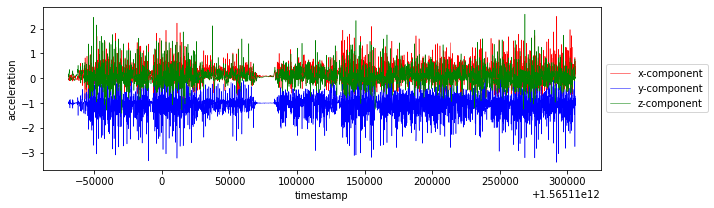

In [8]:
plt.figure(figsize=(10,3))
plt.plot(train_ts['timestamp'], train_ts['x'], linewidth=0.5, color='r', label='x-component')
plt.plot(train_ts['timestamp'], train_ts['y'], linewidth=0.5, color='b', label='y-component')
plt.plot(train_ts['timestamp'], train_ts['z'], linewidth=0.5, color='g', label='z-component')
plt.xlabel('timestamp')
plt.ylabel('acceleration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

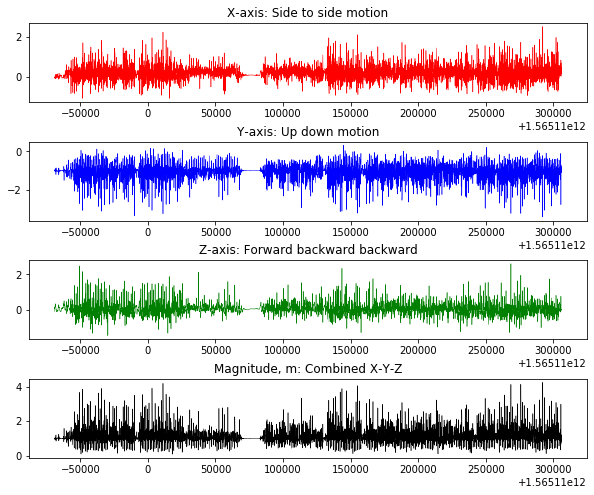

In [9]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis: Side to side motion')
ax[0].plot(train_ts['timestamp'], train_ts['x'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: Up down motion')
ax[1].plot(train_ts['timestamp'], train_ts['y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: Forward backward backward')
ax[2].plot(train_ts['timestamp'], train_ts['z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(train_ts['timestamp'], train_ts['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

### Data Visulization by Activity

In [10]:
# Separating data for each activity
train_df = pd.concat([train_ts, train_labels['label']], axis=1).dropna()
columns = ['timestamp', 'x', 'y', 'z', 'm', 'label']

standing = train_df[columns][train_df.label == 1]
walking = train_df[columns][train_df.label == 2]
stairsdown = train_df[columns][train_df.label == 3]
stairsup = train_df[columns][train_df.label == 4]

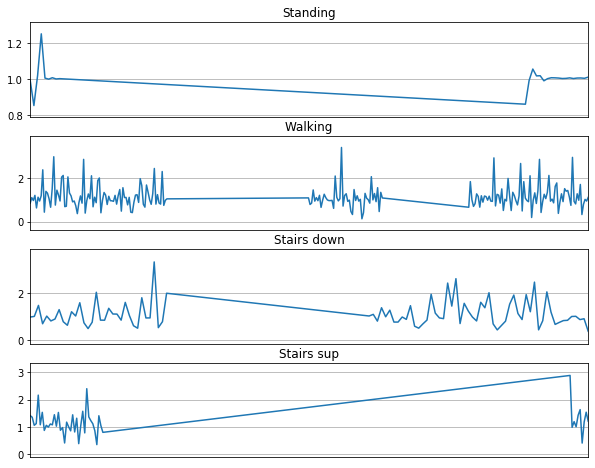

In [11]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['timestamp'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([standing, walking, stairsdown, stairsup],
              ['Standing', 'Walking', 'Stairs down', 'Stairs sup'])

### Sampling Time and Frequency

In [12]:
print("Origital datatype of UTC time:", type(train_ts['UTC time'].iloc[1]))
train_ts['UTC time'] =  pd.to_datetime(train_ts['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
train_labels['UTC time'] =  pd.to_datetime(train_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
print("Updated datatype of UTC time:", type(train_ts['UTC time'].iloc[1]))

Origital datatype of UTC time: <class 'str'>
Updated datatype of UTC time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [13]:
# Sampling time and frequency for time series signals 
T_train_ts = np.mean([train_ts['UTC time'].iloc[i+1]-train_ts['UTC time'].iloc[i] for i in range(len(train_ts['UTC time'])-1)])
f_train_ts = len(train_ts['UTC time'])/(train_ts['UTC time'].iloc[-1]-train_ts['UTC time'].iloc[0]).total_seconds()

print("Time-series signals - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_ts.total_seconds(), f_train_ts))

# Sampling time and frequency for labels
T_train_label = np.mean([train_labels['UTC time'].iloc[i+1]-train_labels['UTC time'].iloc[i] for i in range(len(train_labels['UTC time'])-1)])
f_train_label = len(train_labels['UTC time'])/(train_labels['UTC time'].iloc[-1]-train_labels['UTC time'].iloc[0]).total_seconds()

print("\nActivity labels - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_label.total_seconds(), f_train_label))

Time-series signals - 
Average time per sample: 0.10 seconds
Frequency per sample: 9.98 Hz

Activity labels - 
Average time per sample: 1.00 seconds
Frequency per sample: 1.00 Hz


### Creating Signals and Labels Arrays

In [14]:
train_x_list = [train_ts.x.iloc[start:start+10] for start in range(len(train_labels))]
train_y_list = [train_ts.y.iloc[start:start+10] for start in range(len(train_labels))]
train_z_list = [train_ts.z.iloc[start:start+10] for start in range(len(train_labels))]
train_m_list = [train_ts.m.iloc[start:start+10] for start in range(len(train_labels))]
train_signals = np.transpose(np.array([train_x_list, train_y_list, train_z_list, train_m_list]), (1, 2, 0))
train_labels = np.array(train_labels['label'].astype(int))

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train signals array contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The train labels array contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))

The train signals array contains 375 signals, each one of length 10 and 4 components 
The train labels array contains 375 labels, with the following distribution:
 Counter({2: 213, 3: 88, 4: 47, 1: 27})


In [15]:
def randomize(dataset, labels):
   permutation = np.random.permutation(labels.shape[0])
   shuffled_dataset = dataset[permutation, :]
   shuffled_labels = labels[permutation]
   return shuffled_dataset, shuffled_labels

train_signals, train_labels = randomize(train_signals, np.array(train_labels))

### Frequency Transformation Functions

In [16]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
    
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features_ft(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y
 
def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features_ft(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

### Applying and Visualizing Frequency Transformations

In [17]:
activities_description = {
    1: 'Standing',
    2: 'Walking',
    3: 'Stairs down',
    4: 'Stairs up'
}

N = 10
f_s = 1 #1 Hz for train_labels #10 Hz for train_ts 
t_n = 1 #1 sec for train_labels #0.1 sec for train_ts
T = t_n / N #
sample_rate = 1 / f_s
denominator = 10

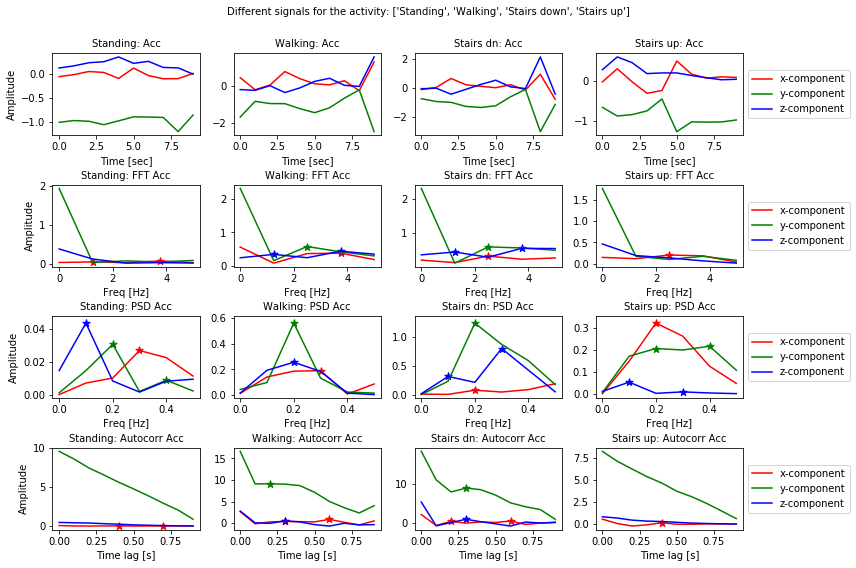

In [18]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Standing: Acc', 'Walking: Acc', 'Stairs dn: Acc', 'Stairs up: Acc'],
            ['Standing: FFT Acc', 'Walking: FFT Acc', 'Stairs dn: FFT Acc', 'Stairs up: FFT Acc'],
            ['Standing: PSD Acc', 'Walking: PSD Acc', 'Stairs dn: PSD Acc', 'Stairs up: PSD Acc'],
            ['Standing: Autocorr Acc', 'Walking: Autocorr Acc', 'Stairs dn: Autocorr Acc', 'Stairs up: Autocorr Acc']
           ]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]
signal_no_list = [5, 20, 160, 120]
activity_name = list(activities_description.values())

f, axarr = plt.subplots(nrows=4, ncols=4, figsize=(12,8))
f.suptitle(suptitle.format(activity_name), fontsize=10)
 
for row_no in range(0,4):
    for col_no in range(0,4):
        for comp_no in range(0,3):
            color = colors[comp_no % 3]
            label = labels[comp_no % 3]

            axtitle  = axtitles[row_no][col_no]
            xlabel = xlabels[row_no]
            value_retriever = list_functions[row_no]

            ax = axarr[row_no][col_no]
            ax.set_title(axtitle, fontsize=10)
            ax.set_xlabel(xlabel, fontsize=10)
            
            if col_no == 0:
                ax.set_ylabel(ylabel, fontsize=10)

            signal_no = signal_no_list[col_no]
            signals = train_signals[signal_no, :, :]
            signal_component = signals[:, comp_no]
            x_values, y_values = value_retriever(signal_component, T, N, f_s)
            ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
            
            if row_no > 0:
                max_peak_height = 0.1 * np.nanmax(y_values)
                indices_peaks = detect_peaks(y_values, mph=max_peak_height)
                ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
            if col_no == 3:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

### Extract Frequency Transformed Features

In [19]:
X_train_ft, Y_train_ft = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
print(X_train_ft.shape)
print(Y_train_ft.shape)

(375, 120)
(375,)


### Train Classifiers

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_ft, Y_train_ft, train_size=0.8, random_state=1)

In [21]:
models = batch_classify(X_train, Y_train, X_val, Y_val)
display_dict_models(models)

trained Gradient Boosting Classifier in 1.99 s
trained Random Forest in 0.33 s
trained Logistic Regression in 0.42 s
trained Nearest Neighbors in 0.05 s
trained Decision Tree in 0.01 s


,classifier,train_score,test_score,train_time
1,Random Forest,1.000000,0.800000,0.327930
0,Gradient Boosting Classifier,1.000000,0.773333,1.994485
4,Decision Tree,1.000000,0.666667,0.008958
2,Logistic Regression,0.736667,0.586667,0.418997
3,Nearest Neighbors,0.740000,0.533333,0.053465


### Resampling for Class Imbalance

In [42]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, Y_ros = ros.fit_sample(X_train, Y_train)
models = batch_classify(X_ros, Y_ros, X_val, Y_val)
display_dict_models(models)

trained Gradient Boosting Classifier in 2.51 s
trained Random Forest in 0.37 s
trained Logistic Regression in 0.12 s
trained Nearest Neighbors in 0.02 s
trained Decision Tree in 0.02 s


,classifier,train_score,test_score,train_time
1,Random Forest,1.000000,0.866667,0.369813
0,Gradient Boosting Classifier,1.000000,0.760000,2.511896
4,Decision Tree,1.000000,0.720000,0.019926
3,Nearest Neighbors,0.865152,0.546667,0.024024
2,Logistic Regression,0.790909,0.520000,0.116340


### Hyperparameter Tuning for Best Classifier

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [44]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=7, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_ros, Y_ros)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [45]:
clf = rf_random.best_estimator_
clf.fit(X_ros, Y_ros)
print("Accuracy on training set is : {}".format(clf.score(X_ros, Y_ros)))
print("Accuracy on validation set is : {}".format(clf.score(X_val, Y_val)))
Y_val_pred = clf.predict(X_val)
print(classification_report(Y_val, Y_val_pred))

Accuracy on training set is : 1.0
Accuracy on validation set is : 0.84
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.93      0.85      0.89        48
           3       0.53      0.90      0.67        10
           4       0.91      0.71      0.80        14

    accuracy                           0.84        75
   macro avg       0.84      0.87      0.84        75
weighted avg       0.88      0.84      0.85        75



In [46]:
print("Counter on validation set:", Counter(Y_val_pred))
print("Predicted activities:\n", list(Y_val_pred))

Counter on validation set: Counter({2: 44, 3: 17, 4: 11, 1: 3})
Predicted activities:
 [2, 1, 2, 2, 4, 4, 3, 3, 3, 2, 4, 2, 2, 2, 1, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 4, 1, 2, 2, 3, 2, 2, 3, 4, 3, 2, 2, 2, 3, 4, 2, 4, 2, 2, 2, 2, 3, 2, 4, 3, 4, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 2, 4]


In [47]:
pred_activities = [activities_description[label] for label in list(Y_val_pred)]
print("Predicted Activities:\n", pred_activities)

Predicted Activities:
 ['Walking', 'Standing', 'Walking', 'Walking', 'Stairs up', 'Stairs up', 'Stairs down', 'Stairs down', 'Stairs down', 'Walking', 'Stairs up', 'Walking', 'Walking', 'Walking', 'Standing', 'Stairs down', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Stairs up', 'Standing', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Stairs down', 'Stairs up', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Stairs down', 'Stairs up', 'Walking', 'Stairs up', 'Walking', 'Walking', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Stairs up', 'Stairs down', 'Stairs up', 'Stairs down', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Stairs down', 'Walking', 'Walking', 'Walking', 'Walking', 'Stairs up', 'Walking', 'Stairs up']
